<a href="https://colab.research.google.com/github/fernandarrios/tcc_covid_recuperacao/blob/main/covid_cases_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19

Segundo a Organização Pan-Americana de Saúde (OPAS), em 31 de dezembro de 2019, a Organização Mundial de Saúde (OMS) foi alertada sobre diversos casos de pneumonia na cidade de Wuhan, província de Hubei, na República Popular da China. Os casos investigados foram causados por uma nova cepa viral ainda não identificada entre os seres humanos, classificada como coronavírus humano SARS-CoV-2. 

Ao todo são sete coronavírus humanos (HCoVs) identificados e classificados: HCoV-229E, HCoV-OC43, HCoV-NL63, HCoV-HKU1, SARS-COV, MERS-COV e o mais recente, o SARS-CoV-2, tido como o novo coronavírus e que causa uma síndrome respiratória aguda grave e que foi responsável por causar a COVID-19.

Em 30 de janeiro de 2020, a OMS declarou que o surto do novo coronavírus constitui uma Emergência de Saúde Pública de Importância Internacional (ESPII) – o mais alto nível de alerta da Organização, conforme previso no Regulamento Sanitário Internacional. Em 11 de março de 2020, a COVID-19 (SARS-CoV-2) foi caracterizada pela OMS como uma pandemia.
Até 21 de setembro de 2022, houve aproximadamente 613 milhões de casos, com 6,53 milhões de mortes no mundo inteiro. No Brasil foram 34,6 milhões de casos, com 685,5 mil mortes. Em Minas Gerais, houve 3,9 milhões de casos com 63,8 mil mortes.

### Objetivo do trabalho

Esse trabalho busca analisar os dados sobre a COVID-19 no Estado de Minas Gerais, desde 01 de janeiro 2020 até 17 de setembro de 2022, disponíveis nos sites do Governo Federal e Governo de Minas Gerais, buscando entender como a pandemia afetou a vida dos mineiros e as características dessas pessoas e construir um modelo que consiga classificar os pacientes que tem chance se recuperar, entrar em recuperação ou de vir a óbito após se contaminar com a COVID-19, usando como variável alvo a informação “Evolução” do paciente, presente no dataset, sendo 1 para “Recuperado”, 2 para “Em acompanhamento” e 3 para “Óbito”.

### Coleta de dados

Os dados foram obtidos no dia 21 de setembro de 2022 no site do Governo Federal e Governo Estadual de Minas Gerais, na seção de informações sobre a pandemia do COVID-19. Mais especificamente, os dados foram pegos dos Sistemas de Informação em Saúde oficiais, E-SUS VE (para casos leves de COVID-19) e SIVEP-GRIPE (para casos graves e óbitos). 
Os dados foram disponibilizados no formato de Excel (.xlsx), são dados estruturados e contém as mesmas colunas. 


##  Importação dos dados

In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, make_scorer, classification_report
from collections import Counter
from pandas_profiling.profile_report import ProfileReport

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [ ]:
def fixing_data_type(column, first_symbol, second_symbol):
    try:
        column = column.apply(lambda x : str(x).replace(first_symbol, second_symbol))
        column = pd.to_datetime(column, format='%Y%m%d')
    except ValueError:
        column = column.apply(lambda x : str(x).replace(first_symbol, second_symbol))
        column = pd.to_datetime(column, dayfirst=True)
    return column


def drop_columns(df, columns):
    df.drop(columns=columns, inplace=True)
    return df


def plot_chart(desired_variable, df, order, title=None, xlabel=None, ylabel=None,
               hue=None, ax=None):
    sns.countplot(y=desired_variable,
                  hue=hue,
                  data=df,
                  palette='rocket',
                  order=order,
                  ax=ax).set_title(title)
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel=ylabel)
    plt.grid(axis='x', linestyle='--')
    plt.minorticks_on()


def plot_box_plot(column, title=None, xlabel=None, ax=None):
    sns.boxplot(column, palette='rocket', ax=ax).set_title(title)
    plt.xlabel(xlabel)
    plt.grid(axis='x', linestyle='--')
    plt.minorticks_on()


def plot_time_series(column, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    ax.hist(column, bins=50, color='#301934')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(axis='y', linestyle='--')
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)


def save_fig_show(figname, image_path):
    plt.savefig(image_path + figname + '.jpeg')
    return plt.show()


def classification_report_with_accuracy_score_tree(y_true, y_pred):
    originalclass_tree.extend(y_true)
    predictedclass_tree.extend(y_pred)
    return accuracy_score(y_true, y_pred)


def classification_report_with_accuracy_score_nb(y_true, y_pred):
    originalclass_nb.extend(y_true)
    predictedclass_nb.extend(y_pred)
    return accuracy_score(y_true, y_pred)


def classification_report_with_accuracy_score_lgbm(y_true, y_pred):
    originalclass_lgbm.extend(y_true)
    predictedclass_lgbm.extend(y_pred)
    return accuracy_score(y_true, y_pred)

In [ ]:
path = 'C:/Users/nanda/PycharmProjects/puc_tcc/data/'
covid_sistema_um = pd.read_csv(f'{path}XLSX_Sistemas_1.txt', sep='\t')
covid_sistema_dois = pd.read_csv(f'{path}XLSX_Sistemas_2.txt', sep='\t')
covid_sistema_tres = pd.read_csv(f'{path}XLSX_Sistemas_3.txt', sep='\t')
covid_sistema_quatro = pd.read_csv(f'{path}xlsx_sistemas.txt', sep='\t')

covid_sistema_um['DATA_NOTIFICACAO'] = fixing_data_type(
    covid_sistema_um['DATA_NOTIFICACAO'], '-', '')
covid_sistema_dois['DATA_NOTIFICACAO'] = fixing_data_type(
    covid_sistema_dois['DATA_NOTIFICACAO'], '-', '')
covid_sistema_tres['DATA_NOTIFICACAO'] = fixing_data_type(
    covid_sistema_tres['DATA_NOTIFICACAO'], '-', '')
covid_sistema_quatro['DATA_NOTIFICACAO'] = fixing_data_type(
    covid_sistema_quatro['DATA_NOTIFICACAO'], '/', '-')

covid_df = pd.concat([covid_sistema_um, covid_sistema_dois, covid_sistema_tres,
                      covid_sistema_quatro])

A variável DATA_NOTIFICACAO presente no dataset apresentou dois formatos de data, (YYYY-MM-DD e DD/MM/YYYY), então foi optado carregar os arquivos separados, para poder tratar essa variável antes de concatená-los em um único dataframe.

In [ ]:
print(covid_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1870100 entries, 0 to 752499
Data columns (total 21 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   URS                   object        
 2   MICRO                 object        
 3   MACRO                 object        
 4   DATA_NOTIFICACAO      datetime64[ns]
 5   CLASSIFICACAO_CASO    object        
 6   SEXO                  object        
 7   IDADE                 float64       
 8   FAIXA_ETARIA          object        
 9   MUNICIPIO_RESIDENCIA  object        
 10  CODIGO                float64       
 11  EVOLUCAO              object        
 12  DATA_EVOLUCAO         object        
 13  DATA_1_SINTOMA        object        
 14  INTERNACAO            object        
 15  UTI                   object        
 16  RACA                  object        
 17  ETNIA                 object        
 18  COMORBIDADE           object        
 19  D

## Tratamento dos dados

Analisando a quantidade de valores nulos.

In [ ]:
print(covid_df.isnull().sum())

ID                            0
URS                        9387
MICRO                      9387
MACRO                      9387
DATA_NOTIFICACAO            908
CLASSIFICACAO_CASO            0
SEXO                          0
IDADE                      1825
FAIXA_ETARIA               1825
MUNICIPIO_RESIDENCIA          0
CODIGO                     8654
EVOLUCAO                      0
DATA_EVOLUCAO           1545769
DATA_1_SINTOMA            38344
INTERNACAO                    0
UTI                           0
RACA                          0
ETNIA                   1869199
COMORBIDADE                   0
DATA_ATUALIZACAO              0
ORIGEM_DA_INFORMACAO          0
dtype: int64


Como podemos ver, 8.9% do dataset é composto de valores nulos. As variáveis ETNIA e DATA_EVOLUCAO foram eliminadas por esse motivo. As variáriveis ID, CODIGO, MUNICIPIO_RESIDENCIA, MICRO, DATA_1_SINTOMA, DATA_ATUALIZACAO, CLASSIFICACAO_CASO foram eliminadas por não gerar valor informacional para a anáise dos dados e no aprendizado de máquina.

In [ ]:
drop_columns(covid_df, ['ID', 'CODIGO', 'DATA_EVOLUCAO', 'ETNIA', 'MUNICIPIO_RESIDENCIA',
                        'MICRO', 'DATA_1_SINTOMA', 'DATA_ATUALIZACAO',
                        'CLASSIFICACAO_CASO'])

,URS,MACRO,DATA_NOTIFICACAO,SEXO,IDADE,FAIXA_ETARIA,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO
0,BELO HORIZONTE,CENTRO,2020-05-26,MASCULINO,27.0,20 A 29 ANOS,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,BOLETIM
1,BELO HORIZONTE,CENTRO,2020-06-23,MASCULINO,68.0,60 A 69 ANOS,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,BOLETIM
2,MONTES CLAROS,NORTE,2020-05-26,FEMININO,20.0,20 A 29 ANOS,RECUPERADO,NAO,NAO,NAO INFORMADO,NAO,BOLETIM
3,CORONEL FABRICIANO,VALE DO ACO,2020-06-21,FEMININO,42.0,40 A 49 ANOS,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,NAO INFORMADO,BOLETIM
4,UNAI,NOROESTE,2020-06-23,MASCULINO,6.0,1 A 9 ANOS,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,BOLETIM
...,...,...,...,...,...,...,...,...,...,...,...,...
752495,UBERABA,TRIANGULO DO SUL,2021-02-26,FEMININO,75.0,70 A 79 ANOS,OBITO,SIM,NAO INFORMADO,BRANCA,SIM,SIVEP
752496,DIVINOPOLIS,OESTE,2021-05-21,FEMININO,79.0,70 A 79 ANOS,OBITO,SIM,NAO,PARDA,SIM,SIVEP
752497,BELO HORIZONTE,CENTRO,2021-03-15,FEMININO,77.0,70 A 79 ANOS,OBITO,SIM,SIM,BRANCA,SIM,SIVEP
752498,BELO HORIZONTE,CENTRO,2021-03-24,FEMININO,82.0,80 A 89 ANOS,OBITO,SIM,NAO,PRETA,SIM,SIVEP


Na análise do ProfileReport, foi detectada outliers nas variáveis DATA_NOTIFICACAO e IDADE. Vamos investigar mais a fundo e tratá-las.

In [ ]:
print(f"Searching for the outlier: \n{covid_df['DATA_NOTIFICACAO'].dt.year.value_counts()}")
print(covid_df.loc[covid_df['DATA_NOTIFICACAO'].dt.year == 1957])

Searching for the outlier: 
2021.0    1160855
2020.0     646374
2022.0      61962
1957.0          1
Name: DATA_NOTIFICACAO, dtype: int64
           URS             MACRO DATA_NOTIFICACAO       SEXO  IDADE  \
45947  UBERABA  TRIANGULO DO SUL       1957-09-19  MASCULINO    0.0   

      FAIXA_ETARIA    EVOLUCAO INTERNACAO  UTI           RACA    COMORBIDADE  \
45947        <1ANO  RECUPERADO        NAO  NAO  NAO INFORMADO  NAO INFORMADO   

      ORIGEM_DA_INFORMACAO  
45947                 ESUS  


In [ ]:
covid_df = covid_df.loc[covid_df['DATA_NOTIFICACAO'].dt.year != 1957]
print(f"After deleting the outlier:\n{covid_df['DATA_NOTIFICACAO'].dt.year.value_counts()}")

After deleting the outlier:
2021.0    1160855
2020.0     646374
2022.0      61962
Name: DATA_NOTIFICACAO, dtype: int64


Analisando a variável IDADE, vemos que a idade mínima é de 0 anos, ou seja, bebês e a idade máxima é de 392, da qual pelo conhecimento científico, é impossível chegar nessa idade, então teremos que explorar melhor essa variável.

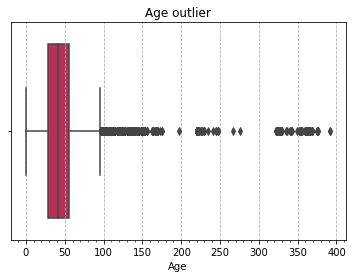

In [ ]:
image_path = 'C:/Users/nanda/PycharmProjects/puc_tcc/images/'

plot_box_plot(covid_df['IDADE'], 'Age outlier', xlabel='Age')
save_fig_show('Age_outlier', image_path=image_path)

O boxplot mostra que há presença de outliers de 100 anos à quase 400 anos. Vamos investigar mais.

In [ ]:
print(f"Looking for the outliers: " 
      f"{covid_df.loc[covid_df['IDADE'] > 100, ['IDADE', 'FAIXA_ETARIA']]}")

Looking for the outliers:         IDADE FAIXA_ETARIA
624     103.0   90 OU MAIS
1084    102.0   90 OU MAIS
1643    101.0   90 OU MAIS
6759    101.0   90 OU MAIS
8870    101.0   90 OU MAIS
...       ...          ...
748021  103.0   90 OU MAIS
749137  101.0   90 OU MAIS
749471  101.0   90 OU MAIS
749803  105.0   90 OU MAIS
751928  101.0   90 OU MAIS

[935 rows x 2 columns]


Para não associar valores incorretos para esses pacientes, essas linhas foram removidas, estabelecendo que 100 anos seria a idade limite,  levando em consideração que a expectativa de vida média da população brasileira é de 72,2 anos para homens e 79,3 anos para mulheres segundo fonte do Instituto Brasileiro de Geografia e estátisitca (IBGE).

In [ ]:
covid_df = covid_df.loc[covid_df['IDADE'] <= 100]

Na variável SEXO, há uma quantidade irrelevante de 'NÃO INFORMADO', logo foi optado por filtrá-las do dataset.

In [ ]:
covid_df = covid_df.loc[covid_df['SEXO'] != 'NAO INFORMADO']

In [ ]:
print(covid_df.duplicated().sum())

852569


Após esse tratamento, restaram 9.362 valores nulos nas variáveis URS e MACRO. Como é um quantidade considerável de dados para eliminar, e considerando que os outros valores já haviam sido filtrados,  optou-se por outra estatégia, preenchendo os valores nulos com o método do pandas fillna() com o argumento method=’ffill’, que propaga a última observação válida para as linhas em branco até a próxima observação válida.

In [ ]:
covid_df.fillna(method='ffill', inplace=True)

In [ ]:
print(covid_df.duplicated().sum())

853561


O dataset disponibilizado tem informações gerais sobre os pacientes, para que  privacidade dos dados pessoais fossem respeitadas, é compreensível haver duplicatas, pois duas pessoas com as mesmas características, morando na mesma cidade podem ter contraído COVID-19 no mesmo período ou ao longo do período analisado, logo manterei as duplicatas.

## Análise Exploratória

##### Macrorregião

As duas Macrorregiões mineiras com maior número de casos da COVID-19 são as Macrorregiões Centro e Sul. A hipótese é que essa discrepância poderia se dar pelo tamanho da população, o que foi confirmada após analisar os Boletins Especiais de COVID-19. 

No Boletim Especial da Macrorregião Centro 02/2022 informa que essa Macrorregião é composta por 101 municípios, totalizando, de forma estimada, 6.658.650 habitantes, representando 31,3% da população e no Boletim Especial da Macrorregião Sul 02/2022 informa que essa Macrorregião é composta por 154 municípios, totalizando, de forma estimada, 2.834.846 habitantes

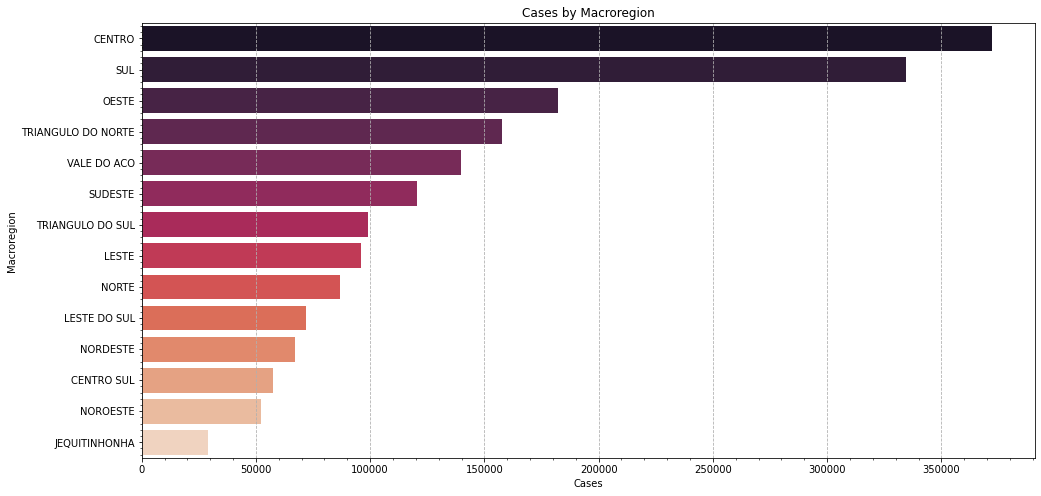

In [ ]:
plt.figure(figsize=(16, 8))
plot_chart(covid_df['MACRO'], covid_df, covid_df['MACRO'].value_counts().index,
           'Cases by Macroregion', xlabel='Cases', ylabel='Macroregion')
save_fig_show('Macroregion_cases', image_path)

##### Unidade Regional de Saúde

A URS com mais casos de COVID-19 é a de Belo Horizonte, com 244.261 casos de COVID-19. Essa regional está localizada na Macrorregião Centro, reforçando a hipótese anterior de que o tamanho da população dos municípios que compunham as Macrorregiões Centro e Sul influenciou para que elas tivessem uma contagem alta de casos em relação às outras Macrorregiões.

In [ ]:
covid_df['URS'].value_counts()

BELO HORIZONTE          245645
DIVINOPOLIS             182312
CORONEL FABRICIANO      139798
POUSO ALEGRE            128920
UBERLANDIA              126547
VARGINHA                121060
UBERABA                  98907
GOVERNADOR VALADARES     96154
ITABIRA                  77645
MONTES CLAROS            63162
UBA                      54958
ALFENAS                  48578
SETE LAGOAS              46896
BARBACENA                45404
MANHUACU                 43450
PONTE NOVA               38584
TEOFILO OTONI            38234
JUIZ DE FORA             38024
PASSOS                   35899
PATOS DE MINAS           33311
ITUIUTABA                31181
DIAMANTINA               31021
PEDRA AZUL               28970
UNAI                     18700
LEOPOLDINA               17298
PIRAPORA                 13538
SAO JOAO DEL REI         11876
JANUARIA                 10025
Name: URS, dtype: int64

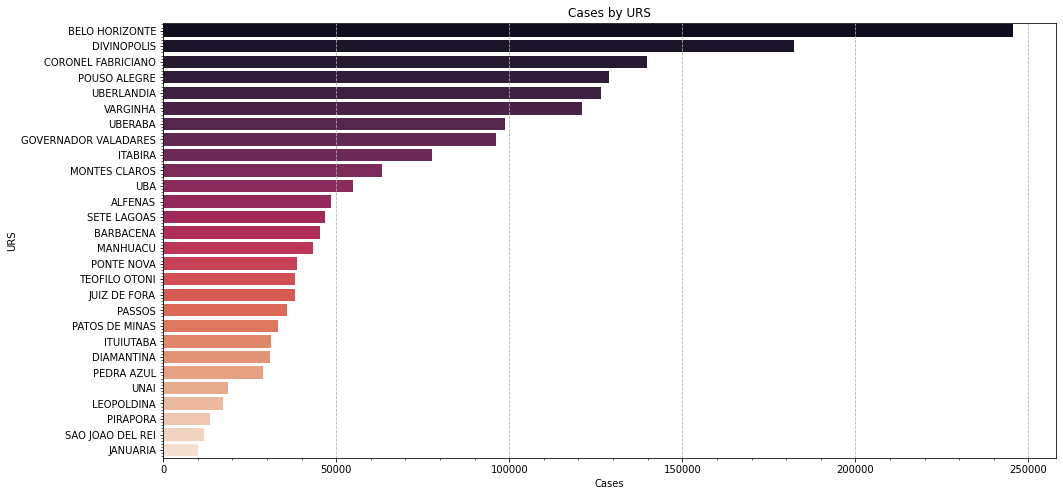

In [ ]:
plt.figure(figsize=(16, 8))
plot_chart(covid_df['URS'], covid_df, covid_df['URS'].value_counts().index,
           'Cases by URS', 'Cases', 'URS')
save_fig_show('Cases_by_urs', image_path)

##### Portal de Saúde

O portal de saúde que mais realizou exames foi o ESUS, com 1.517.326 casos registrados, portal dedicado para casos leves de COVID-19, depois foi o SIVEP com 344.088 casos, portal dedicado para casos graves de COVID-19.

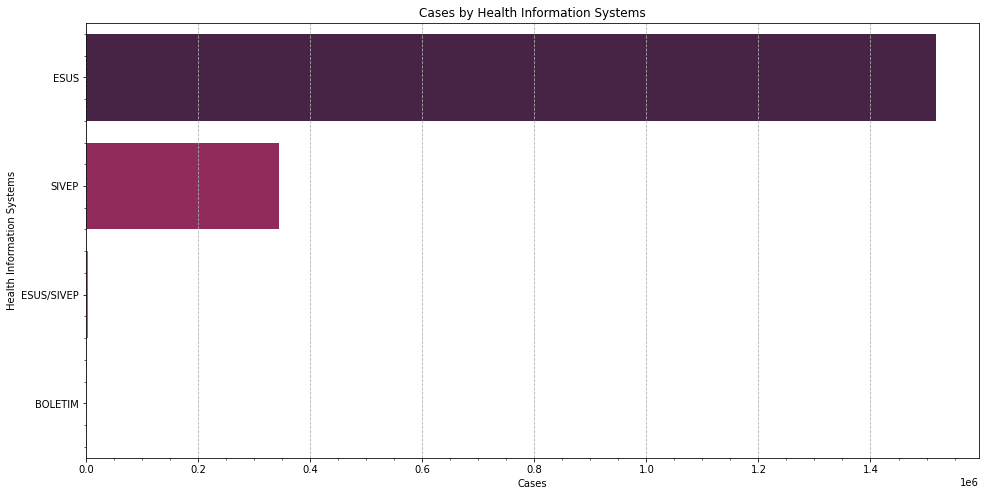

In [ ]:
plt.figure(figsize=(16, 8))
plot_chart('ORIGEM_DA_INFORMACAO', covid_df, covid_df['ORIGEM_DA_INFORMACAO'].value_counts().index,
           'Cases by Health Information Systems', 'Cases', 'Health Information Systems')
values = covid_df['ORIGEM_DA_INFORMACAO'].value_counts()
save_fig_show('Health_Information_Systems', image_path)

##### Casos por decorrer do tempo

Ao analisar o histograma abaixo, Minas Gerais começou a registrar casos de COVID-19 em março de 2020, em novembro de 2020 ocorreu uma leve queda nos registros dos casos, que ficou conhecida como a Primeira Onda, depois da afrouxada nas medidas de segurança contra a contaminação, os casos aumentaram, até por volta de julho de 2021, apesar da campanha de vacinação ter começado em janeiro de 2021. Esse pico de casos mesmo com as vacinas, pode ter relação com o fato de que a vacinação se deu em ordem de grupos determinados por fatores como idade, presença ou não de comorbidade, profissão, logo, as pessoas que ainda não tinham atingido os requisitos necessários continuaram expostas ao vírus.

<Figure size 1152x576 with 0 Axes>

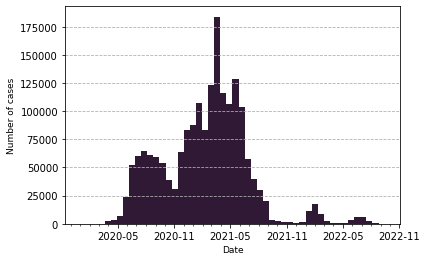

In [ ]:
plt.figure(figsize=(16, 8))
plot_time_series(covid_df['DATA_NOTIFICACAO'], 'Date', 'Number of cases')
save_fig_show('Number_of_cases_over_time', image_path)

#####  Faixa Etária

Hipótese reforçada quando analisamos a faixa de idade das pessoas contaminadas, que foram de 20 anos a 59 anos, pessoas aptas para trabalhar, sendo exposta à contaminação, e com a prioridade de vacina baixa.

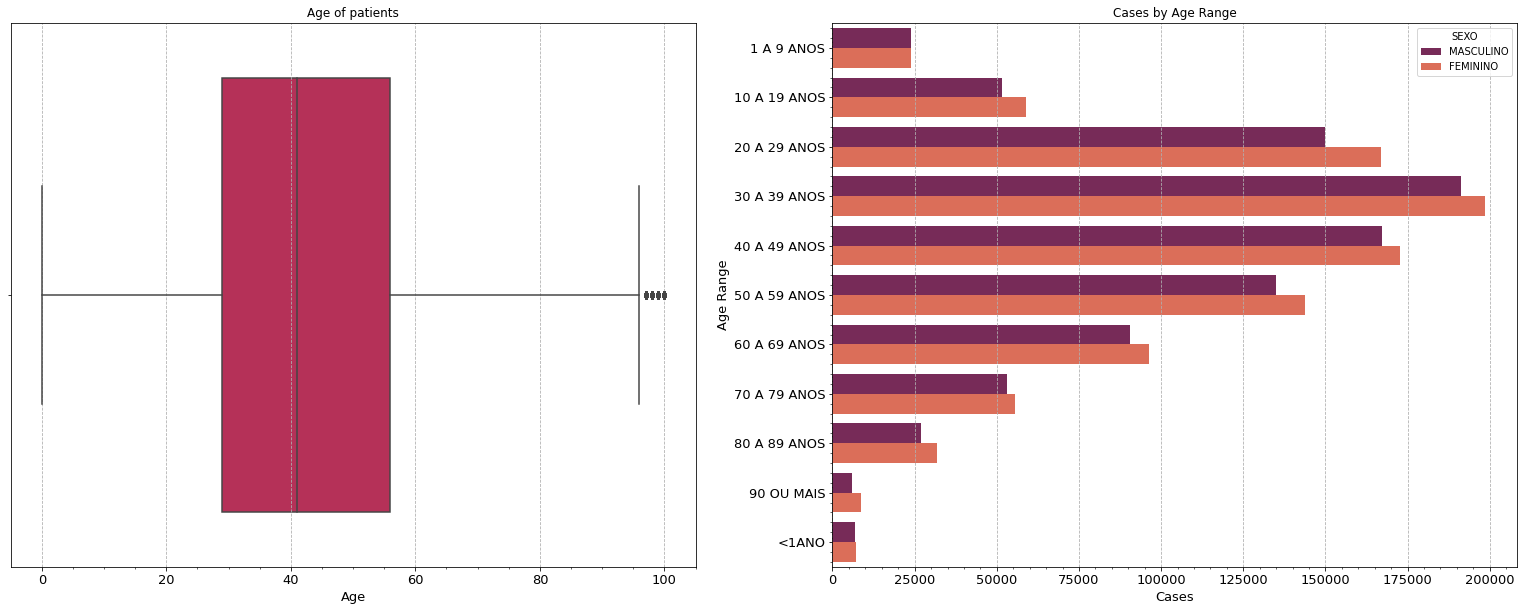

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(27, 10))
plot_chart('FAIXA_ETARIA', covid_df, covid_df['FAIXA_ETARIA'].value_counts().sort_index().index,
           'Cases by Age Range', hue='SEXO', ax=ax[1])
plot_box_plot(covid_df['IDADE'], 'Age of patients', ax=ax[0])
ax[0].set_xlabel(xlabel='Age', fontsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].grid(axis='x', linestyle='--')
ax[0].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_xlabel(xlabel='Cases', fontsize=13)
ax[1].set_ylabel(ylabel='Age Range', fontsize=13)
ax[1].grid(axis='x', linestyle='--')
ax[1].minorticks_on()
save_fig_show('Age', image_path)

##### Comorbidade

Analisando a presença de comorbidade, percebe-se que há uma grande quantidade de pacientes que não teve mapeado se tinha ou não comorbidade. Isso pode ter ocorrido por diversos motivos como comorbidades que não são facilmente detectadas como hipertensão, doença crônica neurológica, entre outros que necessitariam que fossem explicitamente falados, e dependendo do estado na qual se encontrava o paciente quando realizou o exame, não foi possível.

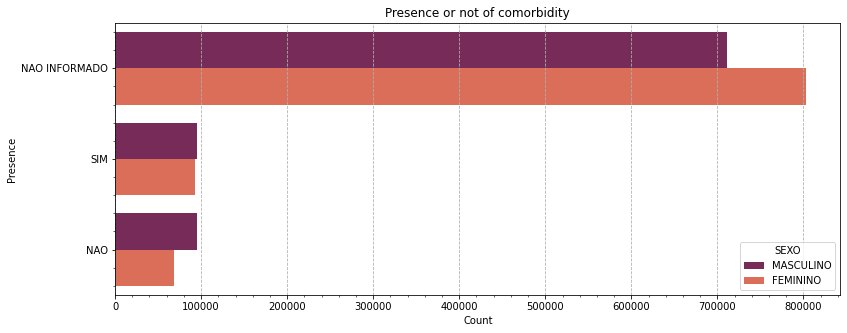

In [ ]:
plt.figure(figsize=(13, 5))
covid_df['COMORBIDADE'].value_counts()
plot_chart('COMORBIDADE', covid_df, covid_df['COMORBIDADE'].value_counts().index,
           'Presence or not of comorbidity', xlabel='Count', ylabel='Presence', hue='SEXO')
save_fig_show('Comorbidity', image_path)

#####  Raça

De acordo com o Censo de 2010 do IBGE, 45,1% da população de Minas Gerais se autode-clara como Branca, 44,6% de autodeclara como Parda, 9,2% como negra, 1% como amare-la e apenas 0,2% como indígena. Esse Censo explica por que os pacientes mais atingidos foram as pessoas pardas e brancas, e a porcentagem baixa de indígenas, contrariando assim a teoria levantada anteriormente de que houve poucos registros de indígenas por-que eles não tiveram acesso às URS.

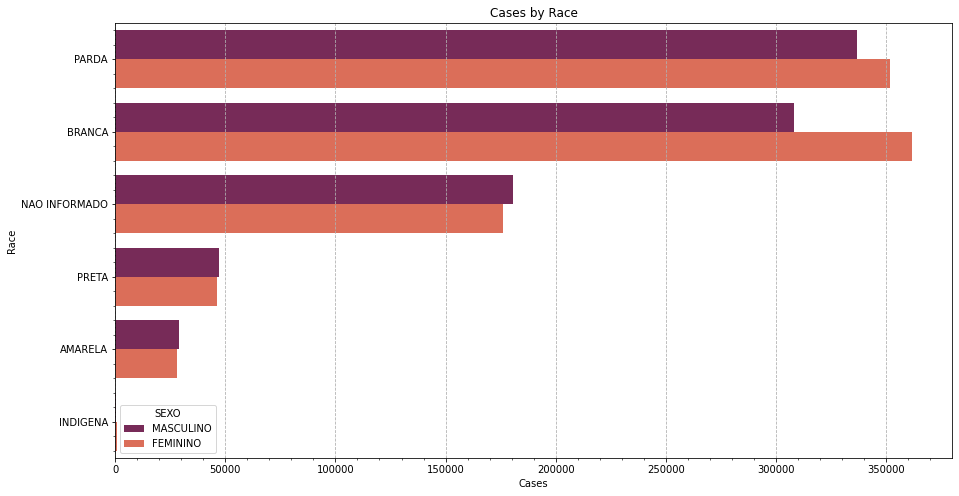

In [ ]:
plt.figure(figsize=(15, 8))
plot_chart('RACA', covid_df, covid_df['RACA'].value_counts().index, title='Cases by Race',
           ylabel='Race', xlabel='Cases', hue='SEXO')
save_fig_show('Race', image_path)

##### Casos de internação e Casos de UTI

Os dois gráficos a seguir mostram a quantidade de pessoas que ficaram internadas e a quantidade de pessoas que foram para a UTI, respectivamente. Como podemos ver, nos dois casos, houve mais casos negativos, ou seja, não foram internadas ou não foram para UTI, do que casos positivos, ou seja, que foram internados ou foram para a UTI. 

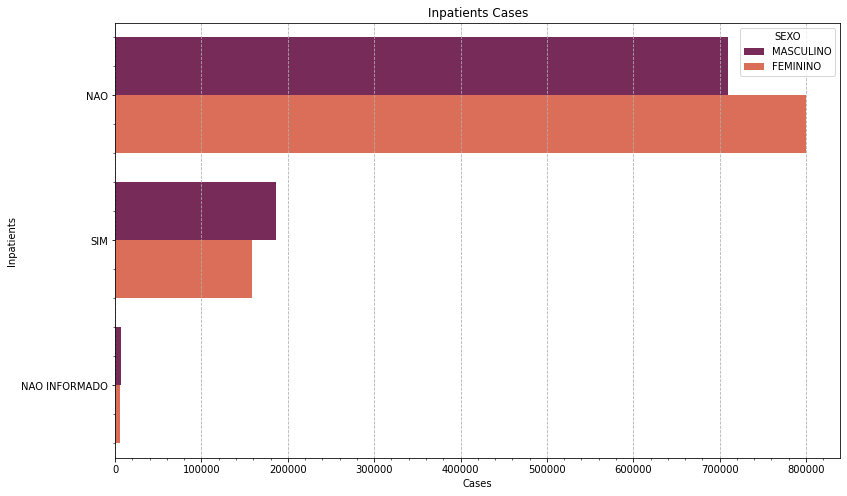

In [ ]:
plt.figure(figsize=(13, 8))
plot_chart('INTERNACAO', covid_df, covid_df['INTERNACAO'].value_counts().index,
           title='Inpatients Cases', xlabel='Cases', ylabel='Inpatients', hue='SEXO')
save_fig_show('Inpatients', image_path)


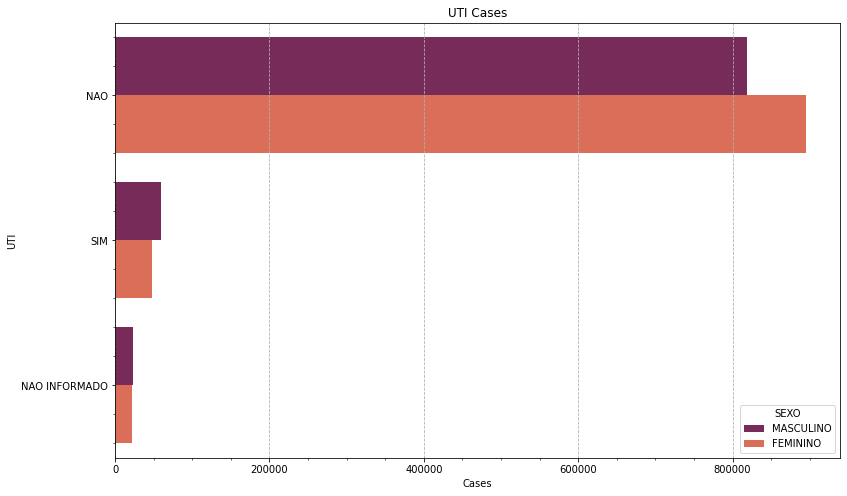

In [ ]:
plt.figure(figsize=(13, 8))
plot_chart('UTI', covid_df, covid_df['UTI'].value_counts().index, title='UTI Cases',
           xlabel='Cases', ylabel='UTI', hue='SEXO')
save_fig_show('UTI_cases', image_path)

Sobre esses fatos, há duas hipóteses:
 - Houve mais pacientes com sintomas leves da COVID-19, não necessitando de cuidados mais intensivos;
 - A capacidade total das Unidades Regionais de Saúde chegou no limite, impossibilitando a admissão de todos os casos que precisavam de internação, dando alta para os pacientes menos críticos;
 
A hipótese que é reforçada pelos dados é de que houve mais pacientes com sintomas leves que sintomas graves, uma vez que os registros de pacientes que se recuperaram da COVID-19, se sobressaíram sobre os registros de óbitos e pacientes que estão em recuperação, além de que o portal que mais registou pacientes foi o ESUS, portal destinado para casos leve.

##### Evolução de saúde dos casos

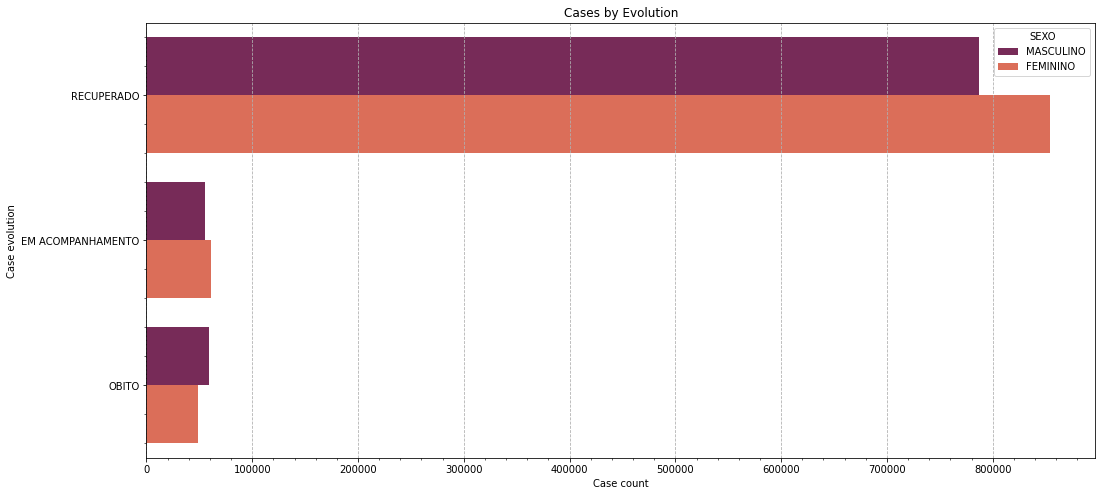

In [ ]:
plt.figure(figsize=(17, 8))
plot_chart('EVOLUCAO', covid_df, covid_df['EVOLUCAO'].value_counts().index,
           title='Cases by Evolution', xlabel='Case count', ylabel='Case evolution',
           hue='SEXO')
save_fig_show('Evolution_by_sex', image_path)

## Preparação do Modelo

Primeiramente, foram eliminadas as variáveis IDADE, ORIGEM_DA_INFORMACAO, DATAA_NOTIFICACAO, pois:
- IDADE: Idade no formato numérico, irei utilizar para o modelo a versão categórica dessa informação.
- ORIGEM_DA_INFORMACAO: Dado referente ao laboratório que realizou o exame no paciente. O local aonde o exame foi realizado não afeta na possibilidade de sobreviência ou não do paciente.
- Variável de série temporal, será eliminada para simplificar o modelo.

In [ ]:
drop_columns(covid_df, ['DATA_NOTIFICACAO', 'ORIGEM_DA_INFORMACAO', 'IDADE'])

,URS,MACRO,SEXO,FAIXA_ETARIA,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE
0,BELO HORIZONTE,CENTRO,MASCULINO,20 A 29 ANOS,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO
1,BELO HORIZONTE,CENTRO,MASCULINO,60 A 69 ANOS,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO
2,MONTES CLAROS,NORTE,FEMININO,20 A 29 ANOS,RECUPERADO,NAO,NAO,NAO INFORMADO,NAO
3,CORONEL FABRICIANO,VALE DO ACO,FEMININO,40 A 49 ANOS,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,NAO INFORMADO
4,UNAI,NOROESTE,MASCULINO,1 A 9 ANOS,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO
...,...,...,...,...,...,...,...,...,...
752495,UBERABA,TRIANGULO DO SUL,FEMININO,70 A 79 ANOS,OBITO,SIM,NAO INFORMADO,BRANCA,SIM
752496,DIVINOPOLIS,OESTE,FEMININO,70 A 79 ANOS,OBITO,SIM,NAO,PARDA,SIM
752497,BELO HORIZONTE,CENTRO,FEMININO,70 A 79 ANOS,OBITO,SIM,SIM,BRANCA,SIM
752498,BELO HORIZONTE,CENTRO,FEMININO,80 A 89 ANOS,OBITO,SIM,NAO,PRETA,SIM


Após a eliminação das colunas que não serão usadas, realizou-se o processo de encode das variáveis remanescentes.

In [ ]:
encoded_df = pd.get_dummies(covid_df, columns=['SEXO', 'INTERNACAO', 'UTI', 'RACA',
                                               'MACRO', 'COMORBIDADE', 'URS'],
                            drop_first=True, dtype='int64')

faixa_idade_dict = {
    '<1ANO' : 1,
    '1 A 9 ANOS': 2,
    '10 A 19 ANOS': 3,
    '20 A 29 ANOS': 4,
    '30 A 39 ANOS': 5,
    '40 A 49 ANOS': 6,
    '50 A 59 ANOS': 7,
    '60 A 69 ANOS': 8,
    '70 A 79 ANOS': 9,
    '80 A 89 ANOS': 10,
    '90 OU MAIS': 11
}
evolucao_dict = {'RECUPERADO': 1, 'EM ACOMPANHAMENTO': 2, 'OBITO': 3}

encoded_df['FAIXA_IDADE_ORDINAL'] = encoded_df.FAIXA_ETARIA.map(faixa_idade_dict)
encoded_df['EVOLUCAO_ORDINAL'] = encoded_df.EVOLUCAO.map(evolucao_dict)
drop_columns(encoded_df, ['FAIXA_ETARIA', 'EVOLUCAO'])

,SEXO_MASCULINO,INTERNACAO_NAO INFORMADO,INTERNACAO_SIM,UTI_NAO INFORMADO,UTI_SIM,RACA_BRANCA,RACA_INDIGENA,RACA_NAO INFORMADO,RACA_PARDA,RACA_PRETA,MACRO_CENTRO SUL,MACRO_JEQUITINHONHA,MACRO_LESTE,MACRO_LESTE DO SUL,MACRO_NORDESTE,MACRO_NOROESTE,MACRO_NORTE,MACRO_OESTE,MACRO_SUDESTE,MACRO_SUL,MACRO_TRIANGULO DO NORTE,MACRO_TRIANGULO DO SUL,MACRO_VALE DO ACO,COMORBIDADE_NAO INFORMADO,COMORBIDADE_SIM,URS_BARBACENA,URS_BELO HORIZONTE,URS_CORONEL FABRICIANO,URS_DIAMANTINA,URS_DIVINOPOLIS,URS_GOVERNADOR VALADARES,URS_ITABIRA,URS_ITUIUTABA,URS_JANUARIA,URS_JUIZ DE FORA,URS_LEOPOLDINA,URS_MANHUACU,URS_MONTES CLAROS,URS_PASSOS,URS_PATOS DE MINAS,URS_PEDRA AZUL,URS_PIRAPORA,URS_PONTE NOVA,URS_POUSO ALEGRE,URS_SAO JOAO DEL REI,URS_SETE LAGOAS,URS_TEOFILO OTONI,URS_UBA,URS_UBERABA,URS_UBERLANDIA,URS_UNAI,URS_VARGINHA,FAIXA_IDADE_ORDINAL,EVOLUCAO_ORDINAL
0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1
1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2
4,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752495,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9,3
752496,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,3
752497,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,3
752498,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,3


Analisando a correlação entre as variáveis. Optou-se por manter todas elas.

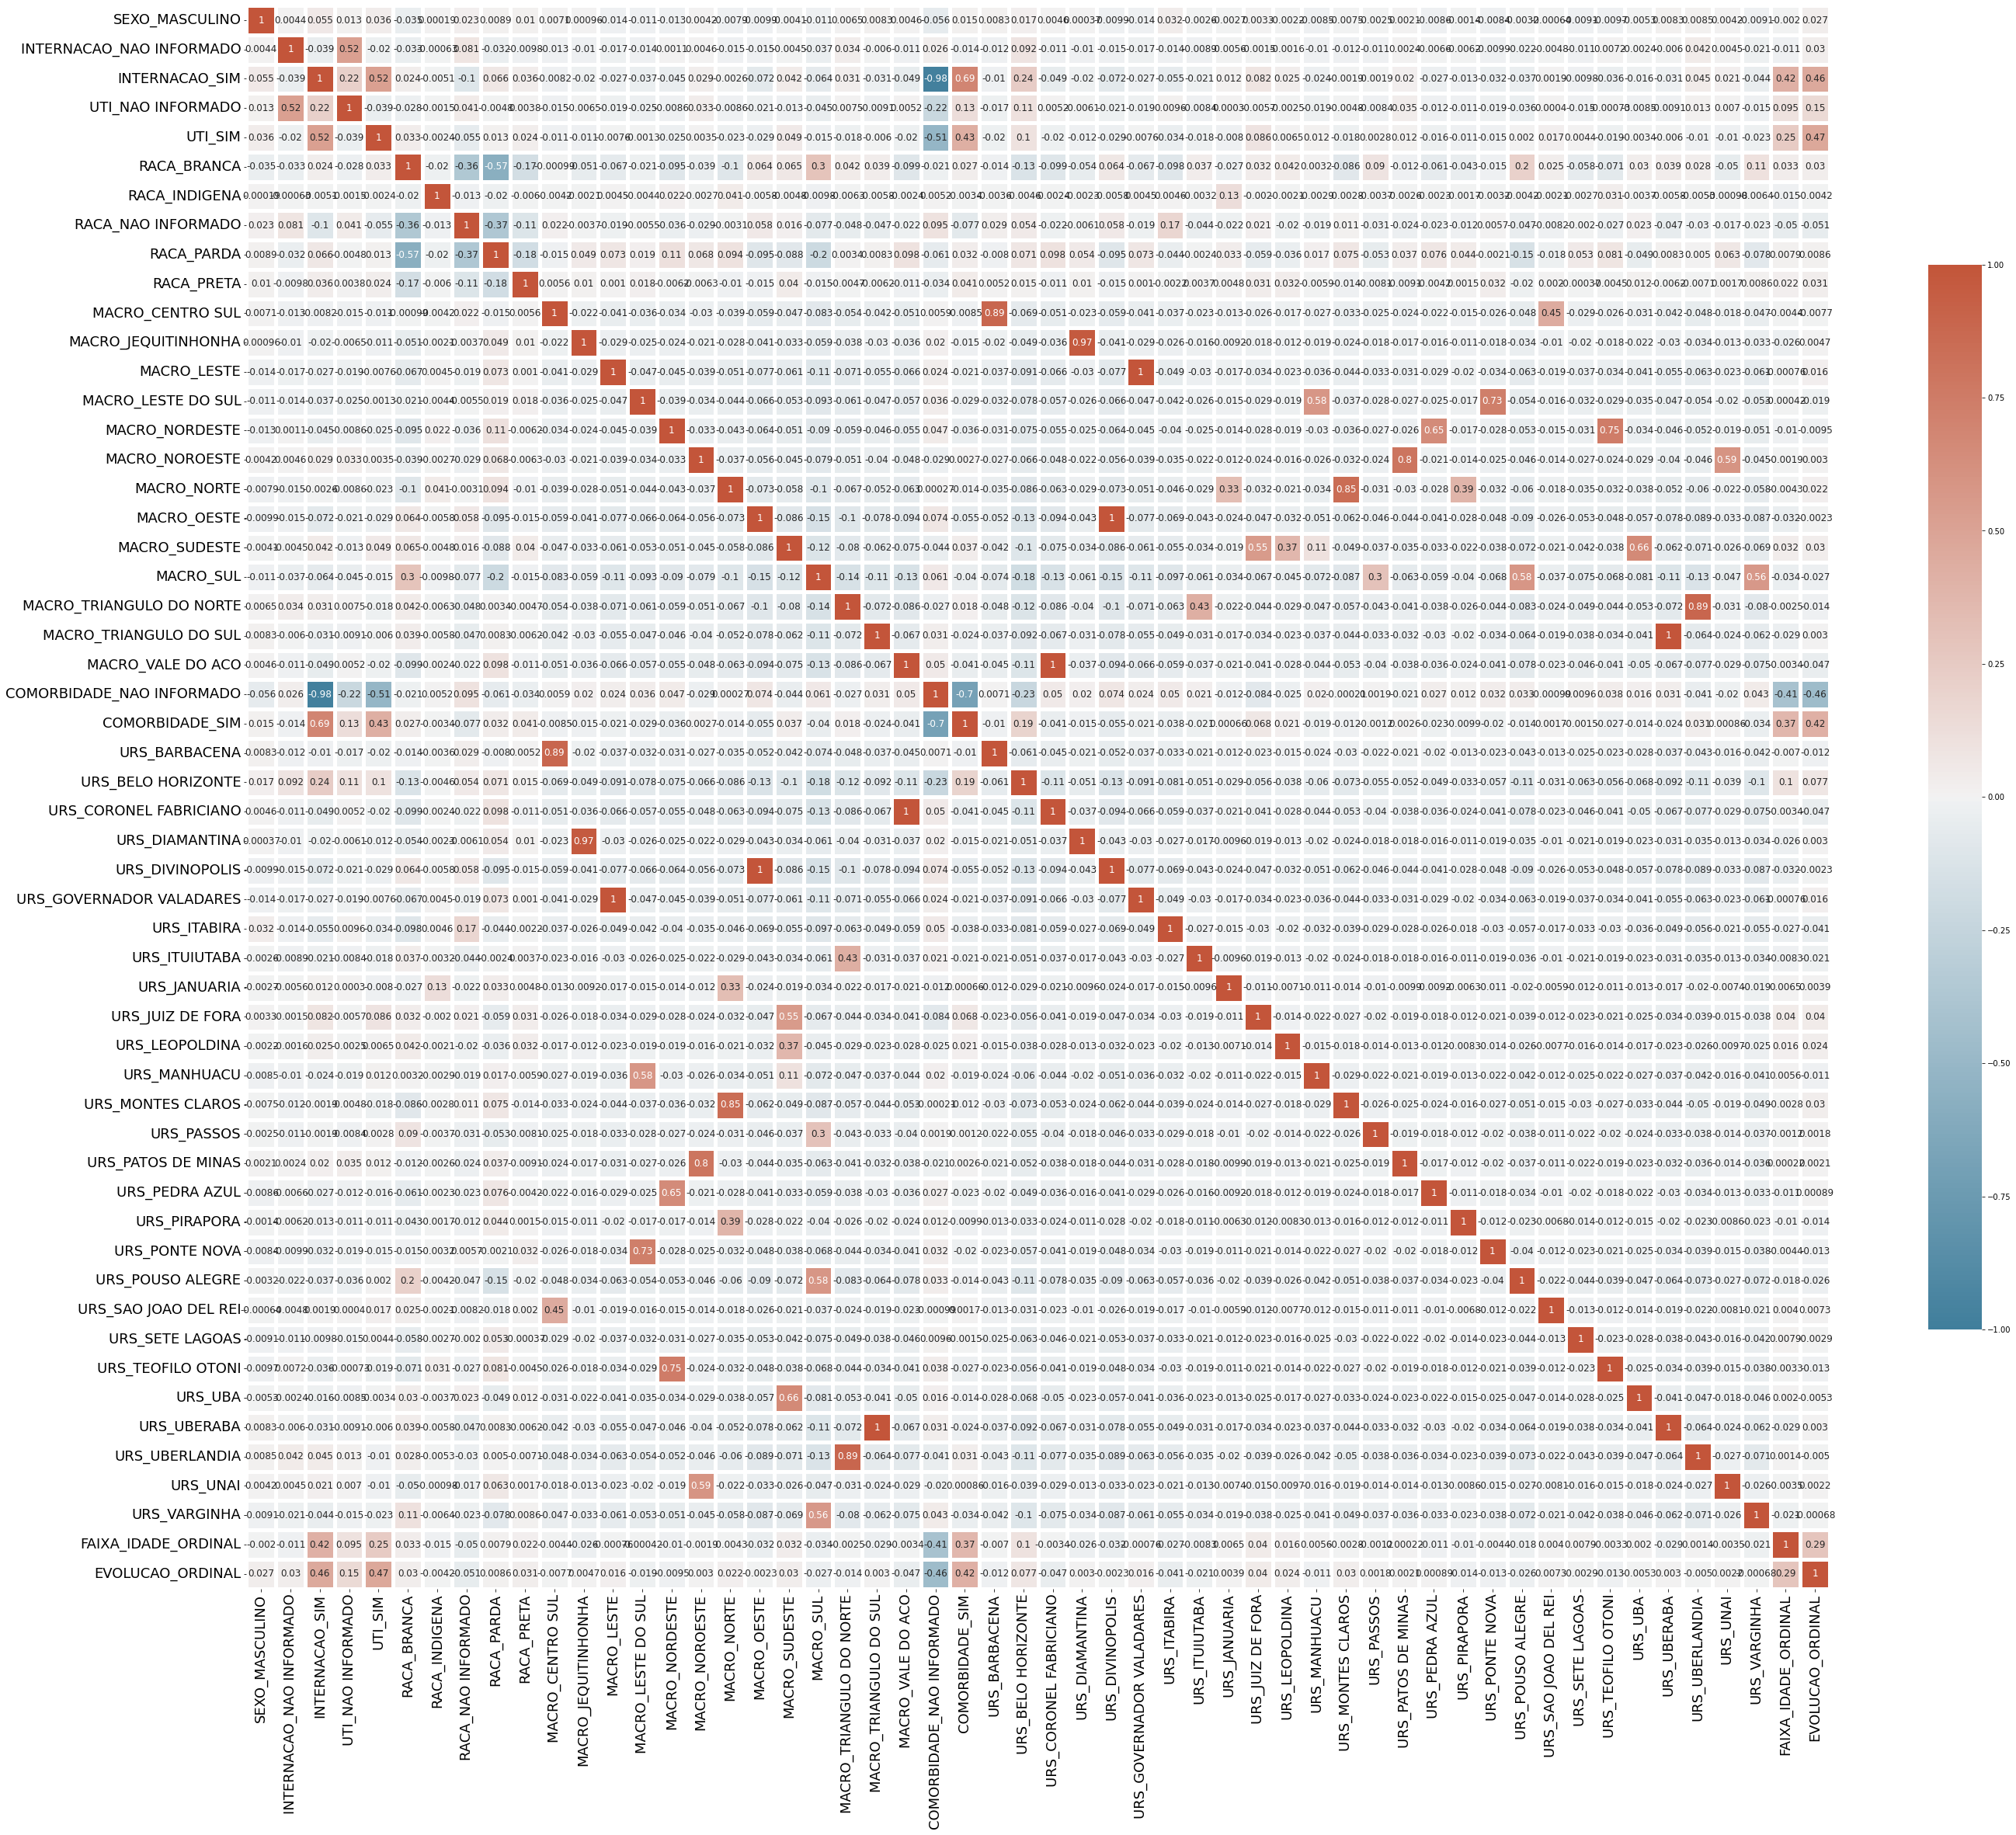

In [ ]:
corr = encoded_df.corr()
plt.figure(figsize=(40, 40))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
graph = sns.heatmap(corr, cmap=cmap, center=0, vmin=-1, vmax=1, annot=True, square=True,
                    linewidths=5, cbar_kws={'shrink': 0.5}, annot_kws={'size': 12})
graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize=18)
graph.set_yticklabels(graph.get_ymajorticklabels(), fontsize=18)
plt.tight_layout()
plt.savefig('Correlation.jpeg')

Separação da variável alvo.

In [ ]:
y = encoded_df['EVOLUCAO_ORDINAL']
X = drop_columns(encoded_df, ['EVOLUCAO_ORDINAL'])

Para balancear essa variável, foi aplicado o RandomUnderSampling da biblioteca Sklearn para reduzir a quantidade de dados da classe predomintante e depois aplicado o RandomOverSampling para aumentar as classes minoritárias e igualar com a classe predominante. Essa combinação de balanceamento impede que ao aplicar só o RandomUnderSampling perca-se uma quantidade considerável de informação para a aprendizagem de máquina, e quando aplicado apenas o  RandomOverSampling a probabilidade de ocorrer o overfitting aumenta, uma vez que faz cópias exatas dos exemplos da classe minoritária. Os valores foram determinados de forma arbitrária, no entanto com a preocupação de manter a mesma quantidade total de dados.

In [ ]:
sampling_strategy_under = {1: 622033, 2: 116135, 3: 108466}
under = RandomUnderSampler(replacement=True, sampling_strategy=sampling_strategy_under,
                           random_state=42)
print('Original dataset shape %s' % Counter(y))
X_resampled, y_resampled = under.fit_resample(X, y)
print(f'Resampled dataset shape whith RandonUnderSample: {Counter(y_resampled)}.')

Original dataset shape Counter({1: 1641496, 2: 116135, 3: 108466})
Resampled dataset shape whith RandonUnderSample: Counter({1: 622033, 2: 116135, 3: 108466}).


In [ ]:
sampling_strategy_over = {1: 622033, 2: 622032, 3: 622032}
over = RandomOverSampler(sampling_strategy=sampling_strategy_over, random_state=42)
X_combined_sampling, y_combined_sampling = over.fit_resample(X_resampled, y_resampled)
print(f'Combined RandomOverSampling with RandonUnderSampling: '
      f'{Counter(y_combined_sampling)}')

Combined RandomOverSampling with RandonUnderSampling: Counter({1: 622033, 2: 622032, 3: 622032})


## Treinamento dos Modelos

#### Decision Tree Classifier

O algoritmo Decision Tree Classifier é composto por vários pontos de deci-são. Esses pontos são os “nós” da árvore e em cada um deles o resultado da deci-são irá seguir por um caminho, ou por outro. Os caminhos existentes são os “ra-mos”. O ponto inicial do algoritmo é com uma pergunta, onde se tem duas opções de resposta: sim ou não. A opção “sim” levará a uma próxima pergunta e a opção “não a outra. 

Estas novas perguntas também terão como opções de resposta o sim e não, e desta for-ma toda a árvore será construída, terminando quando não há mais dado suficiente para responder essa pergunta.

In [ ]:
model = DecisionTreeClassifier()

originalclass_tree = []
predictedclass_tree = []

inner_cv_tree = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv_tree = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

p_grid_tree = {'criterion': ['entropy'], 'random_state': [42], 'max_depth': [20]}

clf_tree = GridSearchCV(estimator=model, param_grid=p_grid_tree, cv=inner_cv_tree)

nested_score_tree = cross_val_score(clf_tree, X=X_combined_sampling, y=y_combined_sampling,
                                    cv=outer_cv_tree, scoring=
                                    make_scorer(classification_report_with_accuracy_score_tree))

print(classification_report(originalclass_tree, predictedclass_tree))

              precision    recall  f1-score   support

           1       0.70      0.59      0.64    622033
           2       0.67      0.67      0.67    622032
           3       0.84      0.97      0.90    622032

    accuracy                           0.74   1866097
   macro avg       0.74      0.74      0.74   1866097
weighted avg       0.74      0.74      0.74   1866097



#### Categorical Naivy Bayes

O classificador Naive Bayes é um algoritmo que se baseia nas descobertas de Thomas Bayes para realizar predições em aprendizagem de máquina. O termo “naive” (ingênuo) diz respeito à forma como o algoritmo analisa as características de uma base de dados: ele assume que as features são independentes entre si. 

Além disso, ele também assume que as variáveis features são todas igualmente importantes para o resultado. 

In [ ]:
modelnb = CategoricalNB()

originalclass_nb = []
predictedclass_nb = []

inner_cv_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

p_grid_nb = {}

clf_nb = GridSearchCV(estimator=modelnb, param_grid=p_grid_nb, cv=inner_cv_nb)

nested_score_rf = cross_val_score(clf_nb, X=X_combined_sampling, y=y_combined_sampling,
                                  cv=outer_cv_nb, scoring=
                                  make_scorer(classification_report_with_accuracy_score_nb))

print(classification_report(originalclass_nb, predictedclass_nb))

              precision    recall  f1-score   support

           1       0.67      0.59      0.63    622033
           2       0.66      0.58      0.62    622032
           3       0.80      0.99      0.88    622032

    accuracy                           0.72   1866097
   macro avg       0.71      0.72      0.71   1866097
weighted avg       0.71      0.72      0.71   1866097



#### Light Gradient Boost Classifier

LightGBM é um framework e uma variante do Gradient Boosting, e é baseado em algoritmos de árvore de decisão. A principal diferença entre o LightGBM e outros fra-meworks de gradiente boosting, é que o LightGBM se expande na direção vertical, o que significa que cresce em folha, enquanto os outros algoritmos se expandem hori-zontalmente em uma direção de nível.

O LightGBM seleciona a folha que produz o menor erro e a máxima eficiência. Esse método é muito mais útil para reduzir a porcentagem de erro. 

In [ ]:
modelgbm = LGBMClassifier()

originalclass_lgbm = []
predictedclass_lgbm = []

inner_cv_lgbm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv_lgbm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

p_grid_lgbm = {'random_state': [42], 'max_depth': [10]}

clf_lgbm = GridSearchCV(estimator=modelgbm, param_grid=p_grid_lgbm, cv=inner_cv_lgbm)

nested_score_lgbm = cross_val_score(clf_lgbm, X=X_combined_sampling, y=y_combined_sampling,
                                    cv=outer_cv_lgbm, scoring=
                                  make_scorer(classification_report_with_accuracy_score_lgbm))

print(classification_report(originalclass_lgbm, predictedclass_lgbm))

              precision    recall  f1-score   support

           1       0.70      0.58      0.64    622033
           2       0.67      0.66      0.67    622032
           3       0.82      0.98      0.89    622032

    accuracy                           0.74   1866097
   macro avg       0.73      0.74      0.73   1866097
weighted avg       0.73      0.74      0.73   1866097



## Resultado

Em comparação com os outros modelos, o Decision Tree Classifier foi o que melhor avaliou todas as classes, tendo margem para melhorar a classificação das pessoas que entrarão em recuperação e as pessoas recuperadas, mas acertando quase em sua totalidade as pessoas que irão morrer.

Apesar disso, todos os modelos testados tiveram uma pior performance nas pes-soas que se recuperaram, e uma alta performance para as pessoas que entraram em óbi-to e uma média performance para as pessoas que estão em recuperação. A partir disso a hipótese levantada é que ter aplicado o RandomOverSampling pode ter contribuído para isso. Pois houve mais dados diferentes de pessoas que se recuperaram, e para as outras duas classes foi gerada uma grande quantidade de dados iguais, logo os modelos não foram capazes de ter uma grande generalização dos dados.